In [2]:
# import packges
import numpy as np
from pathlib import Path
import mjp_inference as mjpi
import matplotlib.pyplot as plt
from mjp_inference.util.conv import discretize_trajectory
import torch
import pyro
from pyro import poutine
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
from pyro.infer.autoguide.initialization import init_to_value
import mjp_inference.wrapper.pyro as mjpp

from pyro.distributions.torch_distribution import TorchDistribution

To illustrate the value of posterior path inference, we investigate a simple switching Poisson process. The process is observed over $[0, 40]$. Let the process have rate $\lambda_1=1$ on $[0, 20]$ and $\lambda_2 = 3$ on $[20, 40]$. A full observation of such a process would comprise of all jump times and the corresponding exact count numbers. In practice, one typically has access to incomplete information. For our example scenario, we assume that the process is sampled every $3s$ and the count is corrupted by Gaussian noise of strength $\sigma=0.25$. A sample path $x$ and the corresponding noisy observations $y$ are shown in (Fig. xxx).

In in inference scenario, we only have access to the noisy observations $y$ and want to estimate parameters $\lambda$ and optionally the latent path $x$. We model the data with a Poison process and assume a uniform prior on the unknown rate $\lambda$. 
The posterior of interest is thus of the form
$$
p(\lambda, x \mid y) \propto p(\lambda) p(x \mid \lambda) p(y \mid x)
$$
The approach developed in this work integrates out the latent paths by solving a master equation and directly targets $p(\lambda \mid y)$.
Running our modelling framework yields the posterior shown in the figure.

In [31]:
# set up model for first part
model1 = mjpi.MJP(name='poisson 1')
# add species
model1.add_species(name='Count', upper=150)
# add an event
model1.add_event(mjpi.Event(name='birth', input_species=['Count'], output_species=['Count'], rate=1.0, propensity=lambda x: 1, change_vec=[1]))
model1.build()

# set up model for second part
model2 = mjpi.MJP(name='poisson 2')
# add species
model2.add_species(name='Count', upper=150)
# add an event
model2.add_event(mjpi.Event(name='birth', input_species=['Count'], output_species=['Count'], rate=3.0, propensity=lambda x: 1, change_vec=[1]))
model2.build()

# set up an observation model
sigma = 0.5
obs_model = mjpi.NormalObs(model1, sigma, observed_species='Count')

In [32]:
# set initial conditions
np.random.seed(2401022301+2)
tspan1 = np.array([0.0, 20.0])
tspan2 = np.array([20.0, 40.0])
initial = np.array([0.0])

In [33]:
# simulate first trajectory part
seed = np.random.randint(2**18)
simulator = mjpi.Simulator(model1, initial, tspan1, seed)
tr1 = simulator.simulate()

# simulate second trajectory part
initial2 = tr1['states'][-1]
seed = np.random.randint(2**18)
simulator = mjpi.Simulator(model2, initial2, tspan2, seed)
tr2 = simulator.simulate()

In [34]:
# create a combined trajectory
trajectory = {
    'initial': tr1['initial'],
    'tspan': np.array([tspan1[0], tspan2[1]]),
    'times': np.concatenate([tr1['times'], tr2['times']]),
    'events': np.concatenate([tr1['events'], tr2['events']]),
    'states': np.concatenate([tr1['states'], tr2['states']]),
}

# create observations
delta_t = 3
t_obs = np.arange(delta_t, trajectory['tspan'][1], delta_t)
obs = discretize_trajectory(trajectory, t_obs, obs_model)

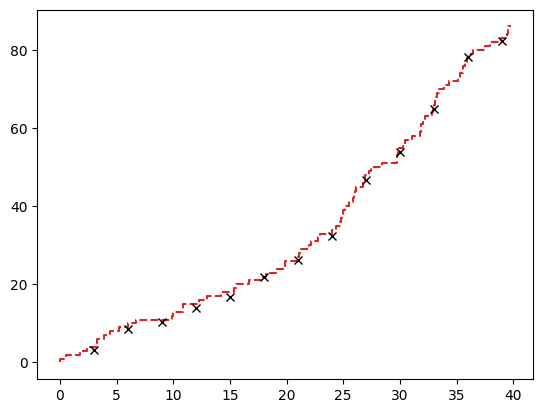

In [35]:
# extend states and time by first
t_plot = np.concatenate([trajectory['tspan'][[0]], trajectory['times']])
states_plot = np.concatenate([trajectory['initial'][:, None], trajectory['states']])

# plot simulated data
fig, axs = plt.subplots()
# plt.plot(t_eval, states, '--r')
axs.step(t_plot, states_plot, '--', color='tab:red', where='pre')
axs.plot(t_obs, obs, 'xk')
plt.show()

### HMC

In [36]:
# torch converstions
rates = torch.from_numpy(model1.rate_array)
obs_param = torch.from_numpy(obs_model.param_array)
observations = torch.from_numpy(obs)

# set up a master equation
master_equation = mjpi.MEInference(model1)

# get initial dist
initial_dist = torch.zeros(model1.num_states)
ind = model1.state2ind(np.zeros(model1.num_species))
initial_dist[ind] = 1.0

# create pyro model
def pyro_model(obs=None):
    # draw parameter prior
    rates = pyro.sample('rates', pyro.distributions.Uniform(0.0, 5.0))
    # sample observations
    obs = pyro.sample('obs', mjpp.CTHMM(master_equation, obs_model, torch.from_numpy(t_obs), initial_dist, rates, obs_param), obs=obs)
    return(obs)

In [37]:
# set save path
workdir = %pwd
save_path = Path(workdir).joinpath('switching_poisson', 'hmc.pt')

if not save_path.exists():
    # run inference
    init_fn = init_to_value(values={'rates': rates})
    kernel = NUTS(pyro_model, step_size=0.1, init_strategy=init_fn)
    mcmc = MCMC(kernel, num_samples=200, warmup_steps=1000)
    mcmc.run(observations)
    # store data
    posterior_samples = {k: v.detach().cpu() for k, v in mcmc.get_samples().items()}
    torch.save(posterior_samples, save_path)
else:
    posterior_samples = torch.load(save_path)

Sample: 100%|██████████| 1200/1200 [25:30,  1.28s/it, step size=1.02e+00, acc. prob=0.914]


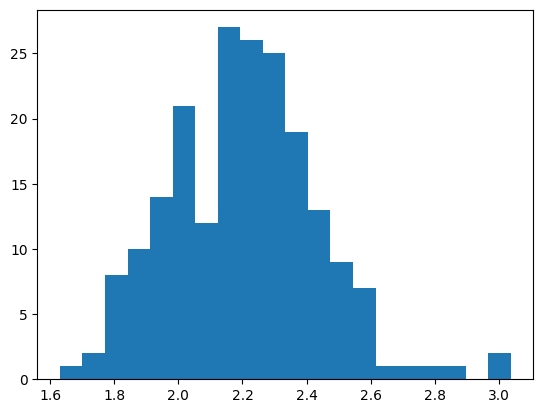

In [38]:
fig, axs = plt.subplots()
axs.hist(posterior_samples['rates'].numpy(), bins=20)
plt.show()

### ADVI

In [39]:

def make_truncated_normal(loc, scale, lower, upper):
    base_dist = pyro.distributions.Normal(loc, scale)
    transforms = [
        pyro.distributions.transforms.SigmoidTransform(),
        pyro.distributions.transforms.AffineTransform(lower, upper-lower)
    ]
    dist = pyro.distributions.TransformedDistribution(base_dist, transforms)
    return dist


def guide(obs=None):
    # Learnable parameters for the distribution
    loc_param = pyro.param("loc_param", torch.tensor(0.0))
    scale_param = pyro.param("scale_param", torch.tensor(1.4), constraint=pyro.distributions.constraints.positive)
    # Parameters for the target interval
    lower = torch.tensor([0.0])
    upper = torch.tensor([5])
    # Create a transformed distribution with the learnable parameters
    transformed_dist = make_truncated_normal(loc_param, scale_param, lower, upper)
    # Sample from the transformed distribution
    rates = pyro.sample("rates", transformed_dist)
    return rates

In [40]:
# fix seed
pyro.set_rng_seed(2403280911)

# Configure the optimizer
adam_params = {"lr": 1e-2}
optimizer = pyro.optim.Adam(adam_params)

# Instantiate the SVI object
svi = pyro.infer.SVI(pyro_model, guide, optimizer, loss=pyro.infer.Trace_ELBO())

save_path = Path(workdir).joinpath('switching_poisson', 'svi.pt')
if not save_path.exists():
# run optimization
    num_iterations = 1500
    losses = torch.zeros(num_iterations)
    loc = torch.zeros(num_iterations)
    scale = torch.zeros(num_iterations)
    pyro.clear_param_store()
    for j in range(num_iterations):
        # Calculate the loss and take a gradient step
        loss = svi.step(observations)
        losses[j] = loss
        loc[j] = pyro.get_param_store()['loc_param'].item()
        scale[j] = pyro.get_param_store()['scale_param'].item()
        if j % 50 == 0:
            print(f"Iteration {j} - Loss: {loss}")
    # store
    torch.save({'losses': losses, 'param_state': pyro.get_param_store().get_state(), 'loc': loc, 'scale': scale}, save_path)
else:
    data = torch.load(save_path)
    losses = data['losses']
    loc = data['loc']
    scale = data['scale']
    pyro.get_param_store().set_state(data['param_state'])

Iteration 0 - Loss: 53.11651797074502
Iteration 50 - Loss: 38.57021820000197
Iteration 100 - Loss: 38.42865169142799
Iteration 150 - Loss: 38.53520712821372
Iteration 200 - Loss: 62.45182316817092
Iteration 250 - Loss: 42.472089682847944
Iteration 300 - Loss: 38.58067671382776
Iteration 350 - Loss: 38.946943965874574
Iteration 400 - Loss: 43.66046710813877
Iteration 450 - Loss: 38.92742269024801
Iteration 500 - Loss: 39.9190415002825
Iteration 550 - Loss: 39.81061355575834
Iteration 600 - Loss: 39.738065200143616
Iteration 650 - Loss: 39.17524311167563
Iteration 700 - Loss: 39.38452745189511
Iteration 750 - Loss: 39.75585778372574
Iteration 800 - Loss: 39.36032765357872
Iteration 850 - Loss: 39.74262697777964
Iteration 900 - Loss: 39.3460836409959
Iteration 950 - Loss: 39.333768947471846
Iteration 1000 - Loss: 39.326509010208966
Iteration 1050 - Loss: 39.39479644811378
Iteration 1100 - Loss: 39.479834064913966
Iteration 1150 - Loss: 39.520375089598836
Iteration 1200 - Loss: 39.48092183

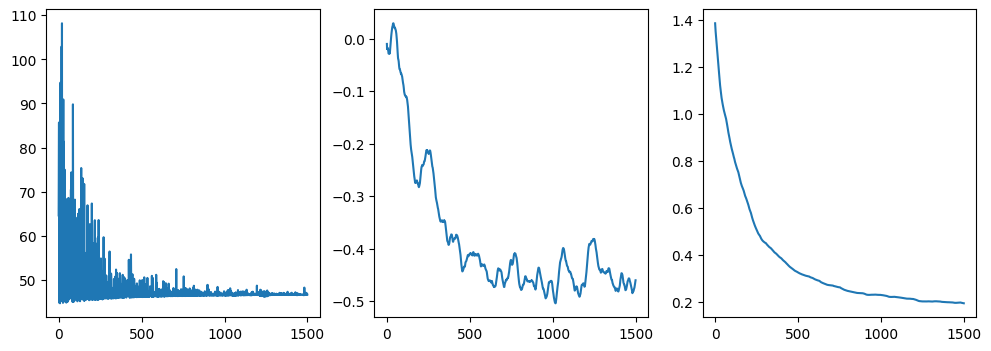

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(loc)
axs[2].plot(scale)
plt.show()

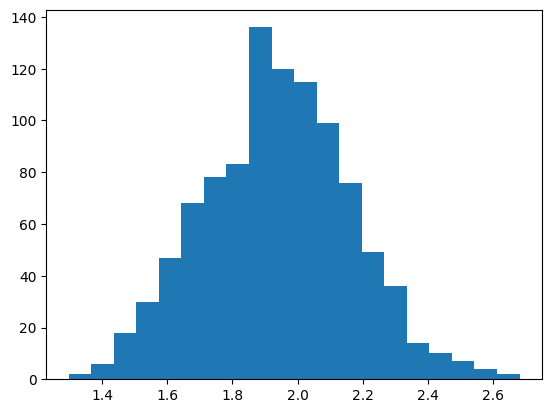

In [14]:
# simulate variational posterior
num_samples = 1000
guide_samples = torch.zeros(num_samples)
for i in range(num_samples):
    guide_samples[i] = guide().item()

fig, axs = plt.subplots()
axs.hist(guide_samples.numpy(), bins=20)
plt.show()

### Interpretation

Recall that for a Poisson-process with rate $\lambda$, the average waiting time between events is $\frac{1}{\lambda}$. The expected number of events in any intervall $\Delta T$ is $\lambda \cdot \Delta t$. We therefore would expect roughly 20 events in the first half of the observed interval and roughly 60 events in the second part of the observed interval. Also note that in case of complete observations, the maximum likelihood estimator is given by
$$
\hat \lambda = \frac{N_{T}}{T}
$$
where $N_T$ is the number of events that occurred in period $T$. We see that both Monte Carlo and variational posterior concentrate on this estimate but with a rather larger variance. 

### Posterior Predictive Check

In order to evaluate a Bayesian model, it is essential to perform posterior predictive checks. Intuitively, this corresponds to generating simulated data based on the fitted model and comparing the simulated data to the real data. Here, we generated 1000 synthetic traces and evaluated the mean and a 95% credible interval (Fig. xxx).

In [15]:
# create posterior predictive
traces_per_samples = 10
traces = []
for i in range(len(posterior_samples['rates'])):
    rate = posterior_samples['rates'][i]
    conditioned_model = poutine.condition(pyro_model, data={'rates': rate})
    for i in range(traces_per_samples):
        obs = conditioned_model()
        traces.append(obs)
traces = np.stack(traces, axis=0).squeeze()

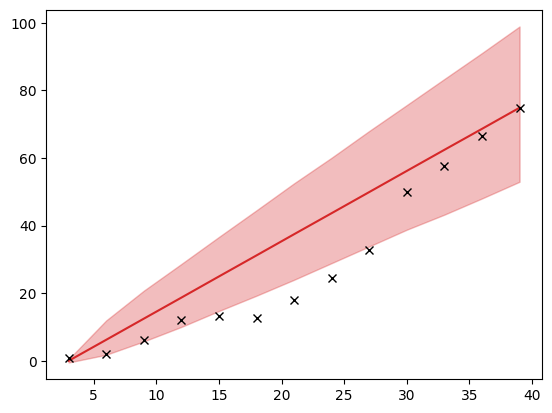

In [16]:
# get stats
mean = np.mean(traces, axis=0)
lower = np.quantile(traces, 0.025, axis=0)
upper = np.quantile(traces, 0.975, axis=0)


# plot simulated data
fig, axs = plt.subplots()
axs.plot(t_obs, mean, color='tab:red')
axs.plot(t_obs, observations.numpy(), 'xk')
axs.fill_between(t_obs, lower, upper, color='tab:red', alpha=0.3)
plt.show()

Several observed points are outside of the credible interval. This can indicate a model mismatch. To get some insight into how to improve the model, the posterior path distribution can be helpful.

### Posterior Paths

In [20]:
save_path = Path(workdir).joinpath('switching_poisson', 'posterior_paths.pt')
tspan = trajectory['tspan']
if not save_path.exists():
    pyro.set_rng_seed(2403281046)
    traces_per_sample = 10
    num_samples = len(posterior_samples['rates'])
    t_post = np.linspace(tspan[0], tspan[1], 100*len(t_obs))
    post_trajectories = []
    post_trajectories_discrete = np.zeros((num_samples, traces_per_sample, len(t_post), 1))
    for i in range(num_samples):
        rate = posterior_samples['rates'][i]
        seed = np.random.randint(2**16)
        # post_trajectory = mjpi.simulate_posterior_batched(master_equation, obs_model, initial_dist, rate, obs_param, tspan, t_obs, observations, t_post, seed, num_samples=traces_per_sample, num_workers=1)
        for j in range(traces_per_sample):
            post_trajectory = mjpi.simulate_posterior(master_equation, obs_model, initial_dist, rate, obs_param, tspan, t_obs, observations, t_post, seed)
            post_trajectories.append(post_trajectory)
            post_trajectories_discrete[i, j] = mjpi.discretize_trajectory(post_trajectory, t_post)
    post_trajectories_discrete = post_trajectories_discrete.reshape((-1,)+post_trajectories_discrete.shape[-2:])
    torch.save({'t_post': t_post, 'post_trajectories': post_trajectories, 'post_trajectories_discrete': post_trajectories_discrete}, save_path)
else:
    data = torch.load(save_path)
    t_post = data['t_post']
    post_trajectories = data['post_trajectories']
    post_trajectories_discrete = data['post_trajectories_discrete']


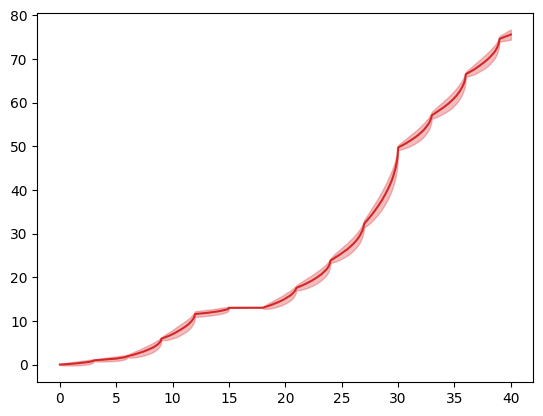

In [21]:
# evaluate some stats
post_mean = post_trajectories_discrete.mean(axis=0).squeeze()
post_std = post_trajectories_discrete.std(axis=0).squeeze()
lower = post_mean - post_std
upper = post_mean + post_std

fig, axs = plt.subplots()
axs.plot(t_post, post_mean, color='tab:red')
axs.fill_between(t_post, lower, upper, color='tab:red', alpha=0.3)
plt.show()

In [22]:
# evaluate average number of init events per unit time
# print(post_trajectories[0])
# for i in range(100):
#     print(post_trajectories[i]['times'])

grid = np.linspace(tspan[0], tspan[1], 41)
num_samples = len(post_trajectories)
hists = np.zeros((num_samples, len(grid)-1))
for i in range(num_samples):
    hists[i] = np.histogram(post_trajectories[i]['times'], bins=grid)[0]


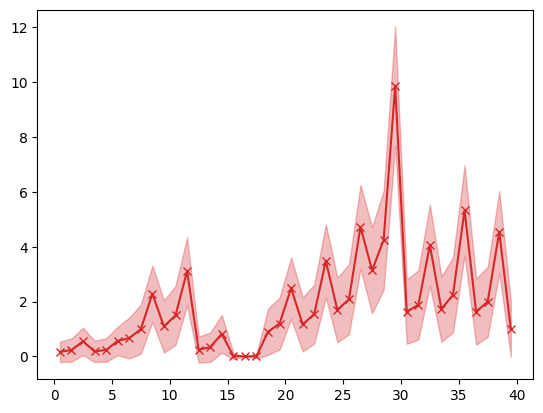

In [24]:
x = 0.5*(grid[:-1] + grid[1:])
hist_mean = hists.mean(axis=0)
hist_std = hists.std(axis=0)
lower = hist_mean - hist_std
upper = hist_mean + hist_std

fig, axs = plt.subplots()
axs.plot(x, hist_mean, '-x', color='tab:red')
axs.fill_between(x, lower, upper, color='tab:red', alpha=0.3)
plt.show()

In [42]:

rate = posterior_samples['rates'][0]
filt = mjpi.KrylovBackwardFilter(master_equation, obs_model, t_obs, observations.numpy(), initial_dist.numpy(), rates, obs_param.numpy(), tspan)
filt.forward_filter()
forward = filt.eval_forward_filter(t_post)
filt.backward_filter()
backward = filt.eval_backward_filter(t_post)
smoothed = forward * backward
smoothed = smoothed / smoothed.sum(axis=1, keepdims=True)


(1300, 151)


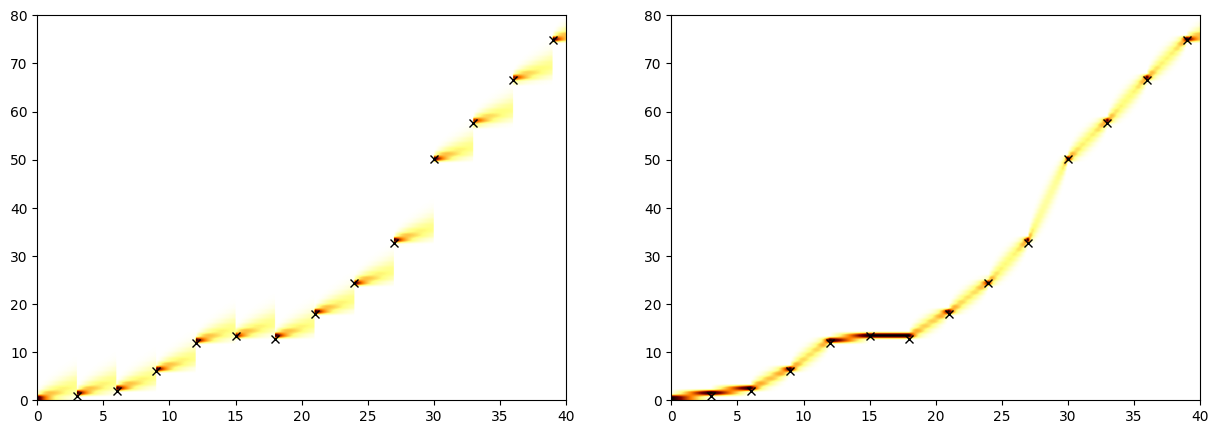

In [51]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
print(forward.shape)
axs[0].imshow(forward.T, cmap='afmhot_r', origin='lower', extent=[tspan[0], tspan[1], 0, 150], aspect='auto')
axs[0].plot(t_obs, observations, 'xk')
axs[0].set_ylim(0, 80)
axs[1].imshow(smoothed.T, cmap='afmhot_r', origin='lower', extent=[tspan[0], tspan[1], 0, 150], aspect='auto')
axs[1].plot(t_obs, observations, 'xk')
axs[1].set_ylim(0, 80)
plt.show()

### Advantages of the Proposed Framework

- Reduction of inifite dimensional problem to finite dimensional one
- Turning a discrete-continuous space into a purely continuous space, thus giving access to powerful gradient-based inference methods
- straightforward reproduction of posterior sample paths via the smoothing generator approach
